In [2]:
import os
import random
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import DataLoader, random_split
from utils.data_loading import BasicDataset, CarvanaDataset

dir_img = Path('./data/imgs/')
dir_mask = Path('./data/masks/')


def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()


try:
    dataset = CarvanaDataset(dir_img, dir_mask, 1)
except (AssertionError, RuntimeError, IndexError):
    dataset = BasicDataset(dir_img, dir_mask, 1)

n_val = int(len(dataset) * 0.1)
n_train = len(dataset) - n_val
train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

loader_args = dict(batch_size=1, num_workers=os.cpu_count(), pin_memory=True)
train_loader = DataLoader(train_set, shuffle=True, **loader_args)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

100%|██████████| 7432/7432 [00:14<00:00, 506.65it/s]


In [16]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score

from utils.dice_score import multiclass_dice_coeff, dice_coeff

@torch.inference_mode()
def evaluate(net, dataloader, device, amp):
    net.to(device).eval()
    num_val_batches = len(dataloader)
    iou_scores = [0] * net.n_classes
    total_true = [0] * net.n_classes
    total_pred = [0] * net.n_classes
    total_correct = [0] * net.n_classes
    precision_list = []
    recall_list = []
    f1_list = []

    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', leave=False):
            image, mask_true = batch['image'], batch['mask']
            image = image.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            mask_true = mask_true.to(device=device, dtype=torch.long)
            mask_pred = net(image)

            if net.n_classes == 1:
                mask_pred = (F.sigmoid(mask_pred) > 0.5).float()
                mask_true = mask_true.float()
            else:
                mask_pred = mask_pred.argmax(dim=1)

            # Flatten the masks
            mask_true = mask_true.view(-1)
            mask_pred = mask_pred.view(-1)

            # Calculate IoU scores
            for i in range(net.n_classes):
                true_positives = ((mask_pred == i) & (mask_true == i)).sum().item()
                false_positives = ((mask_pred == i) & (mask_true != i)).sum().item()
                false_negatives = ((mask_pred != i) & (mask_true == i)).sum().item()
                total_true[i] += (mask_true == i).sum().item()
                total_pred[i] += (mask_pred == i).sum().item()
                total_correct[i] += true_positives

                if (true_positives + false_positives + false_negatives) == 0:
                    iou_scores[i] = 0  # Avoid division by zero
                else:
                    iou_scores[i] += true_positives / (true_positives + false_positives + false_negatives)

            # Calculate Precision, Recall and F1 for each batch
            precision = precision_score(mask_true.cpu().numpy(), mask_pred.cpu().numpy(), average=None)
            recall = recall_score(mask_true.cpu().numpy(), mask_pred.cpu().numpy(), average=None)
            f1 = f1_score(mask_true.cpu().numpy(), mask_pred.cpu().numpy(), average=None)

            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)

    # Calculate average IoU, Precision, Recall and F1
    iou_scores = [iou_score / num_val_batches for iou_score in iou_scores]
    miou = sum(iou_scores[1:]) / (net.n_classes - 1)  # Exclude background class for mIoU
    precision_avg = sum([p for sublist in precision_list for p in sublist[1:]]) / (len(precision_list) * (net.n_classes - 1))
    recall_avg = sum([r for sublist in recall_list for r in sublist[1:]]) / (len(recall_list) * (net.n_classes - 1))
    f1_avg = sum([f for sublist in f1_list for f in sublist[1:]]) / (len(f1_list) * (net.n_classes - 1))
    return iou_scores, miou, precision_avg, recall_avg, f1_avg


In [ ]:
from models.unet import UNet
from models.railnet import parsingNet
from models.unetplusplus import NestedUNet
from models.unet3plus import  UNet3Plus

# 数据路径
unet_model_path = 'checkpoints/unet.pth'
parsingnet_model_path = 'checkpoints/railnet.pth'
unetpp_model_path = 'checkpoints/unetplusplus.pth'
unet3plus_model_path = 'checkpoints/unet3plus.pth'

unet = UNet(n_channels=3, n_classes=9, bilinear=False).load_state_dict(torch.load(unet_model_path))
parsingnet = parsingNet(n_classes=9).load_state_dict(torch.load(parsingnet_model_path))
unetpp = NestedUNet(n_channels=3, n_classes=9).load_state_dict(torch.load(unetpp_model_path))
unet3plus = UNet3Plus(n_channels=3, n_classes=9).load_state_dict(torch.load(unet3plus_model_path))

iou_unet, miou_unet, precision_unet, recall_unet, f1_unet = evaluate(unet, val_loader, device, False)
iou_parsingnet, miou_parsingnet, precision_parsingnet, recall_parsingnet, f1_parsingnet = evaluate(parsingnet, val_loader, device, False)
iou_unetpp, miou_unetpp, precision_unetpp, recall_unetpp, f1_unetpp = evaluate(unetpp, val_loader, device, False)
iou_unet3plus, miou_unet3plus, precision_unet3plus, recall_unet3plus, f1_unet3plus = evaluate(unet3plus, val_loader, device, False)

results = {
    'UNet': {
        'mIoU': miou_unet,
        'Precision': precision_unet,
        'Recall': recall_unet,
        'F1-score': f1_unet
    },
    'UNet++': {

        'mIoU': miou_unetpp,
        'Precision': precision_unetpp,
        'Recall': recall_unetpp,
        'F1-score': f1_unetpp
    },
    'UNet3Plus': {
        
        'mIoU': miou_unet3plus,
        'Precision': precision_unet3plus,
        'Recall': recall_unet3plus,
        'F1-score': f1_unet3plus
    },
    'ParsinNet': {
        'mIoU': miou_parsingnet,
        'Precision': precision_parsingnet,
        'Recall': recall_parsingnet,
        'F1-score': f1_parsingnet
    },
}

import pandas as pd

results_df = pd.DataFrame(results)
results_df.to_csv('results.csv', index=False)

C:\Users\dell\AppData\Local\Temp\ipykernel_19816\1501748318.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet_model.load_state_dict(torch.load(unet_model_path, map_l

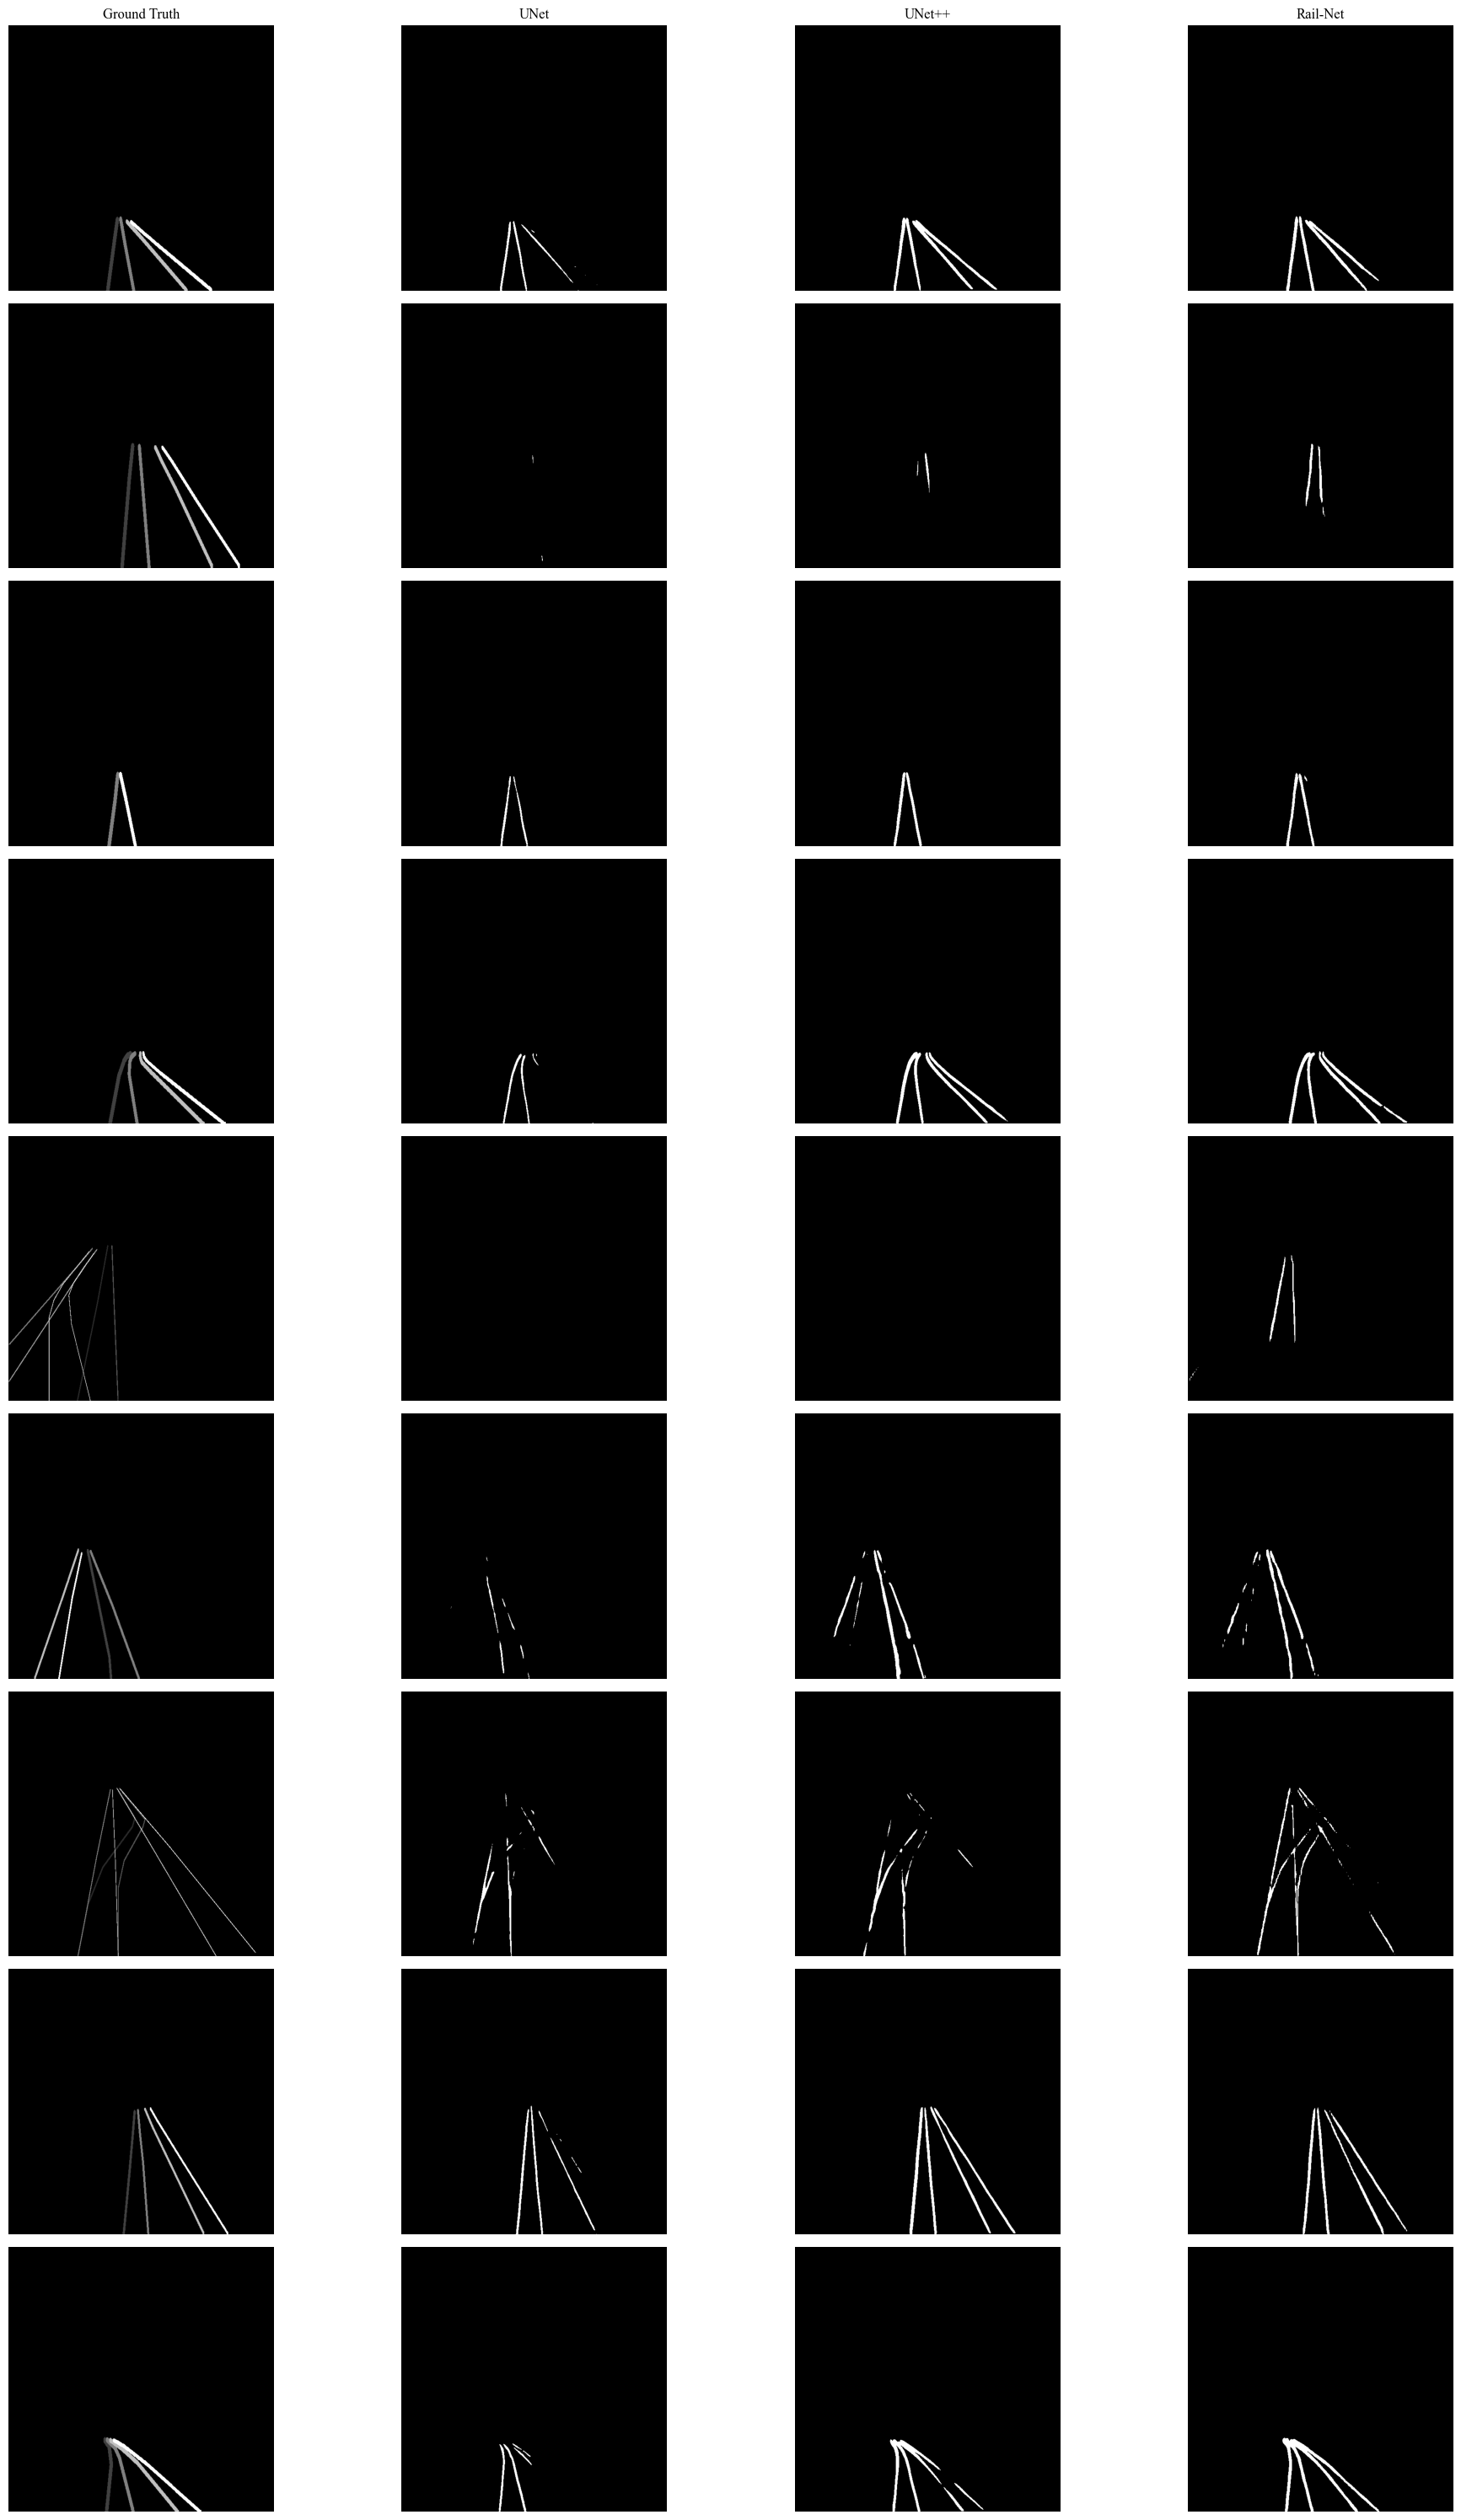

In [22]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
from models.unet import UNet
from models.railnet import parsingNet
from models.unetplusplus import NestedUNet

# 数据路径
imgs_dir = 'data/imgs'
masks_dir = 'data/masks'
unet_model_path = 'models/unet.pth'
parsingnet_model_path = 'models/parsingnet.pth'
unetpp_model_path = 'models/unetpp.pth'

# 图像预处理
preprocess = transforms.Compose([
    transforms.ToTensor(),
])

# 加载UNet模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
unet_model = UNet(n_channels=3, n_classes=9, bilinear=False)
unet_model.load_state_dict(torch.load(unet_model_path, map_location=device))
unet_model.to(device)
unet_model.eval()

# 加载ParsingNet模型
parsingnet_model = parsingNet(n_channels=3, n_classes=9, bilinear=False)
parsingnet_model.load_state_dict(torch.load(parsingnet_model_path, map_location=device))
parsingnet_model.to(device)
parsingnet_model.eval()

# 加载UNet++模型
unetpp_model = NestedUNet(n_channels=3, n_classes=9)
unetpp_model.load_state_dict(torch.load(unetpp_model_path, map_location=device))
unetpp_model.to(device)
unetpp_model.eval()

# 获取图像和掩码的文件名列表
imgs_list = [os.path.join(imgs_dir, file) for file in os.listdir(imgs_dir)]
masks_list = [os.path.join(masks_dir, file) for file in os.listdir(masks_dir)]

# 确保图像和掩码文件名匹配
selected_indices = random.sample(range(len(imgs_list)), 9)
selected_imgs = [imgs_list[i] for i in selected_indices]
selected_masks = [masks_list[i] for i in selected_indices]

# 创建子图网格
fig, axs = plt.subplots(9, 4, figsize=(20, 30))  # 9行4列的子图网格
plt.rcParams['font.sans-serif'] = ['times new roman']  # 设置字体为Times New Roman

# 设置列标题
axs[0, 0].set_title('Ground Truth', fontsize=12)
axs[0, 1].set_title('UNet', fontsize=12)
axs[0, 2].set_title('UNet++', fontsize=12)
axs[0, 3].set_title('Rail-Net', fontsize=12)

for i, (img_path, mask_path) in enumerate(zip(selected_imgs, selected_masks)):
    # 加载图像和掩码
    img = Image.open(img_path).convert('RGB')
    mask = Image.open(mask_path).convert('L')
    
    # 预处理图像
    img_tensor = preprocess(img).unsqueeze(0).to(device)
    
    # UNet模型预测
    with torch.no_grad():
        unet_pred_mask = unet_model(img_tensor)
        unet_pred_mask = torch.argmax(unet_pred_mask, dim=1).squeeze(0).cpu().numpy()
    
    # UNet++模型预测
    with torch.no_grad():
        unetpp_pred_mask = unetpp_model(img_tensor)
        unetpp_pred_mask = torch.argmax(unetpp_pred_mask, dim=1).squeeze(0).cpu().numpy()
    
    # ParsingNet模型预测
    with torch.no_grad():
        parsingnet_pred_mask = parsingnet_model(img_tensor)
        parsingnet_pred_mask = torch.argmax(parsingnet_pred_mask, dim=1).squeeze(0).cpu().numpy()
    
    # 将预测掩码转换为灰度图像
    unet_pred_mask = np.vectorize(lambda x: 1 if x > 0 else 0)(unet_pred_mask)
    unetpp_pred_mask = np.vectorize(lambda x: 1 if x > 0 else 0)(unetpp_pred_mask)
    parsingnet_pred_mask = np.vectorize(lambda x: 1 if x > 0 else 0)(parsingnet_pred_mask)
    
    # 可视化掩码和预测结果
    axs[i, 0].imshow(mask, cmap='gray')
    axs[i, 0].axis('off')
    
    axs[i, 1].imshow(unet_pred_mask, cmap='gray')
    axs[i, 1].axis('off')

    axs[i, 2].imshow(unetpp_pred_mask, cmap='gray')
    axs[i, 2].axis('off')

    axs[i, 3].imshow(parsingnet_pred_mask, cmap='gray')
    axs[i, 3].axis('off')

# 调整子图间距
plt.tight_layout()
plt.show()
